1. Data Cleaning and Preprocessing

In [ ]:
import pandas as pd

data = pd.read_csv("/content/clinical_notes_diagnosis_prediction_5000.csv")

data

,Clinical Notes,Diagnosis
0,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
1,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
2,A 50-year-old male with a history of diabetes ...,Septic Shock
3,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
4,A 55-year-old female with a history of obesity...,Type 2 Diabetes Mellitus
...,...,...
4995,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
4996,"A 40-year-old female presents with swelling, p...",Deep Vein Thrombosis
4997,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
4998,"A 40-year-old female presents with swelling, p...",Deep Vein Thrombosis


In [ ]:
data["Clinical Notes"][10]

'A 55-year-old female with a history of obesity and hypertension presents for a routine check-up. She reports increased thirst, frequent urination, and fatigue over the past few months. On examination, the patient is overweight with a BMI of 32. Blood work shows elevated fasting blood glucose levels of 180 mg/dL. HbA1c levels are 7.5%. The patient is diagnosed with type 2 diabetes and is started on metformin.'

In [ ]:
data["Diagnosis"].value_counts()

,count
Diagnosis,
Peptic Ulcer Disease,284
Type 2 Diabetes Mellitus,283
Acute Myocardial Infarction,272
Chronic Obstructive Pulmonary Disease,269
Cerebrovascular Accident,263
Deep Vein Thrombosis,260
Community-Acquired Pneumonia,251
Chronic Kidney Disease,251
Septic Shock,246


In [ ]:
import nltk
from nltk.corpus import stopwords


import re

import numpy as np

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def clean_text(text):
  text = str(text).lower()
  text = re.sub(r"\d+","", text)
  text = re.sub(r"[^a-z\s]", "", text)
  text = re.sub(r"\s+", " ", text).strip()

  text = " ".join([word for word in text.split() if word not in stop_words])

  return text

# Apply the clenaing function to the clinical notes column

data["Clinical Notes"] = data["Clinical Notes"].apply(clean_text)

In [ ]:
data

,Clinical Notes,Diagnosis
0,yearold male presents heartburn regurgitation ...,Gastroesophageal Reflux Disease
1,yearold male history heavy alcohol use present...,Liver Cirrhosis
2,yearold male history diabetes presents hypoten...,Septic Shock
3,yearold male presents heartburn regurgitation ...,Gastroesophageal Reflux Disease
4,yearold female history obesity hypertension pr...,Type 2 Diabetes Mellitus
...,...,...
4995,yearold male history heavy alcohol use present...,Liver Cirrhosis
4996,yearold female presents swelling pain redness ...,Deep Vein Thrombosis
4997,yearold male history heavy alcohol use present...,Liver Cirrhosis
4998,yearold female presents swelling pain redness ...,Deep Vein Thrombosis


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

data["Diagnosis"] = label_encoder.fit_transform(data["Diagnosis"])

data

,Clinical Notes,Diagnosis
0,yearold male presents heartburn regurgitation ...,9
1,yearold male history heavy alcohol use present...,11
2,yearold male history diabetes presents hypoten...,16
3,yearold male presents heartburn regurgitation ...,9
4,yearold female history obesity hypertension pr...,18
...,...,...
4995,yearold male history heavy alcohol use present...,11
4996,yearold female presents swelling pain redness ...,8
4997,yearold male history heavy alcohol use present...,11
4998,yearold female presents swelling pain redness ...,8


# 2. Tokenization

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(data["Clinical Notes"], data["Diagnosis"], test_size=0.2, random_state=42)



In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length =128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length = 128)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_dict({"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"], "labels": train_labels})
test_dataset = Dataset.from_dict({"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"], "labels": test_labels})



In [ ]:
train_dataset[0]

# 3. Fine Tuning BERT for Diagnosis Prediction

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,

    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    gradient_accumulation_steps=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.012100,0.004311
2,0.004400,0.001527
3,0.003100,0.001131


TrainOutput(global_step=3000, training_loss=0.3391080414131284, metrics={'train_runtime': 548.9954, 'train_samples_per_second': 21.858, 'train_steps_per_second': 5.465, 'total_flos': 400898028960000.0, 'train_loss': 0.3391080414131284, 'epoch': 3.0})

# 4. Evaluation (Confusion Matrix and Classification Report)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy


                                       precision    recall  f1-score   support

          Acute Myocardial Infarction       1.00      1.00      1.00        51
                  Acute Renal Failure       1.00      1.00      1.00        57
                               Asthma       1.00      1.00      1.00        53
             Cerebrovascular Accident       1.00      1.00      1.00        53
               Chronic Kidney Disease       1.00      1.00      1.00        40
Chronic Obstructive Pulmonary Disease       1.00      1.00      1.00        51
         Community-Acquired Pneumonia       1.00      1.00      1.00        48
             Congestive Heart Failure       1.00      1.00      1.00        56
                 Deep Vein Thrombosis       1.00      1.00      1.00        50
      Gastroesophageal Reflux Disease       1.00      1.00      1.00        50
                         Hypertension       1.00      1.00      1.00        40
                      Liver Cirrhosis       1.00   

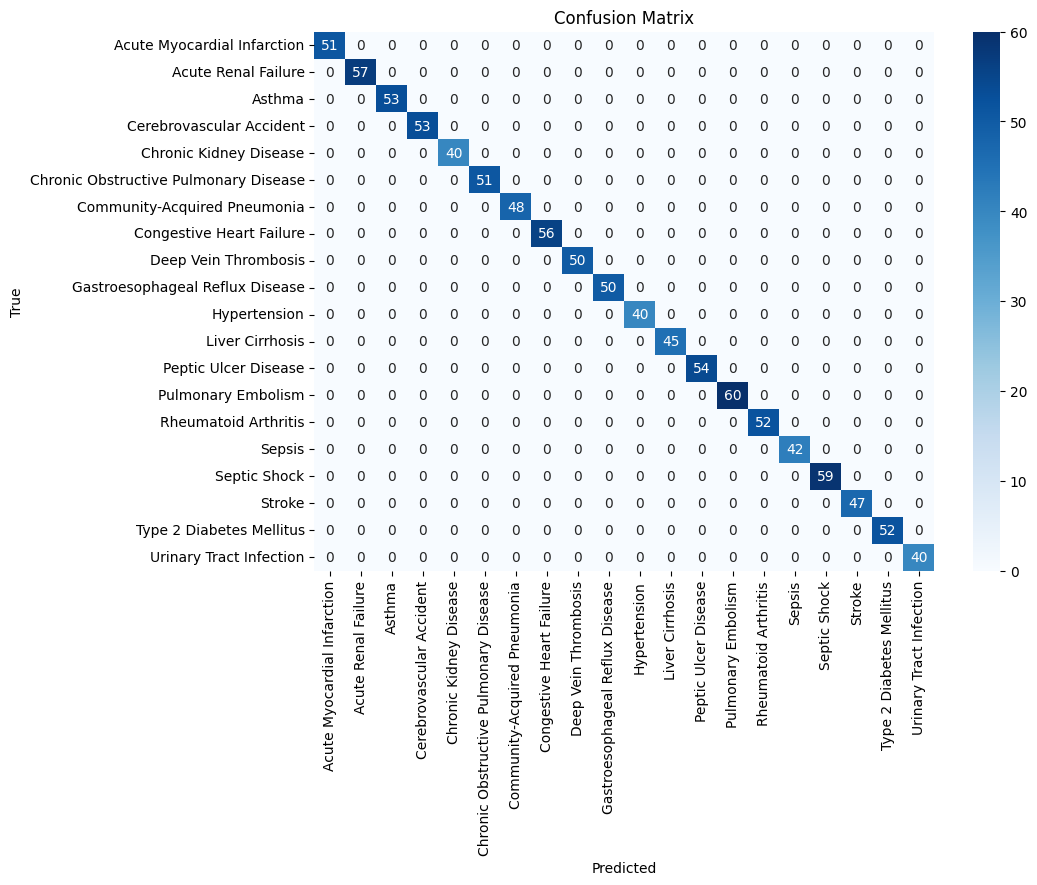

In [ ]:
predictions, labels, _ = trainer.predict(test_dataset)

predicted_class = np.argmax(predictions, axis=1)

print(classification_report(test_labels, predicted_class, target_names=label_encoder.classes_))

plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix(test_labels, predicted_class), annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



# Save the Model and Tokenizer

In [ ]:
trainer.save_model("./patient_model")
trainer.save_state()

tokenizer.save_pretrained("./patient_model")


import pickle

pickle.dump(label_encoder, open("label_encoder.pkl", "wb"))

from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained("./patient_model")
tokenizer = BertTokenizer.from_pretrained("./patient_model")


with open("label_encoder.pkl", "rb") as f:
  label_encoder = pickle.load(f)

lets create a prediction system

In [ ]:
import torch

def predict_disease(patient_note, model, tokenizer, label_encoder):
  patient_note = clean_text(patient_note)
  inputs = tokenizer(patient_note, return_tensors="pt", truncation=True, padding=True, max_length=128)

  with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

  predicted_class = torch.argmax(logits, dim=1).item()

  predicted_disease = label_encoder.inverse_transform([predicted_class])

  return predicted_disease

In [ ]:
# Example Patient Note

patient_note = "Patient presents with fever, headache and fatigue. Medical history inlcudes hypertension"

#make prediction

prediced_disease = predict_disease(patient_note, model, tokenizer, label_encoder)

print(f"Predicted Disease: {prediced_disease[0]}")

Predicted Disease: Pulmonary Embolism


In [ ]:
 # Example patient note (replace with actual patient notes)
patient_note = "'yearold male presents heartburn regurgitation sour taste mouth especially meals patient selfmedicating overthecounter antacids symptoms persist hour ph monitoring test confirms diagnosis gerd patient started ppi advised avoid trigger foods'"

# Make prediction
predicted_disease = predict_disease(patient_note, model, tokenizer, label_encoder)

# Print the prediction
print(f"Predicted Disease: {predicted_disease}")

Predicted Disease: ['Gastroesophageal Reflux Disease']


# Download to PC

In [ ]:
import shutil
from google.colab import files

#zio the saved model directory
shutil.make_archive("patient_model", "zip", "patient_model")

#download the zip file
files.download("patient_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>